<a href="https://colab.research.google.com/github/ozguozkan/DI725_Assignment_1/blob/main/TransformerHW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GITHUB ACCESS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch numpy transformers datasets tiktoken wandb tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
!git clone https://github.com/caglarmert/DI725.git

Cloning into 'DI725'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 242 (delta 59), reused 87 (delta 34), pack-reused 101 (from 1)
Receiving objects: 100% (242/242), 4.37 MiB | 20.82 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [ ]:
!pip install plotly

In [ ]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA


In [ ]:
os.chdir("/content/DI725/assignment_1") #getting into the cloned project
!pwd #cheching where are we

/content/DI725/assignment_1


In [ ]:
!ls data/customer_service #the dataset folder

test.csv  train.csv


**Loading the data and EDA**

In [ ]:
import pandas as pd
train_dataFrame = pd.read_csv("data/customer_service/train.csv")
test_dataFrame = pd.read_csv("data/customer_service/test.csv")

print("train",train_dataFrame.head())
print("test" ,test_dataFrame.head())


train                   issue_area                        issue_category  \
0          Login and Account  Mobile Number and Email Verification   
1  Cancellations and returns                   Pickup and Shipping   
2  Cancellations and returns        Replacement and Return Process   
3          Login and Account       Login Issues and Error Messages   
4                      Order                 Order Delivery Issues   

                                  issue_sub_category  \
0  Verification requirement for mobile number or ...   
1           Reasons for being asked to ship the item   
2             Inability to click the 'Cancel' button   
3  Error message regarding exceeded attempts to e...   
4                       Delivery not attempted again   

                         issue_category_sub_category customer_sentiment  \
0  Mobile Number and Email Verification -> Verifi...            neutral   
1  Pickup and Shipping -> Reasons for being asked...            neutral   
2  Replacem

In [ ]:
#checking the columns and datatypes
print("Train data", train_dataFrame.info())
print("\nTest data", test_dataFrame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   issue_area                   970 non-null    object
 1   issue_category               970 non-null    object
 2   issue_sub_category           970 non-null    object
 3   issue_category_sub_category  970 non-null    object
 4   customer_sentiment           970 non-null    object
 5   product_category             970 non-null    object
 6   product_sub_category         970 non-null    object
 7   issue_complexity             970 non-null    object
 8   agent_experience_level       970 non-null    object
 9   agent_experience_level_desc  970 non-null    object
 10  conversation                 970 non-null    object
dtypes: object(11)
memory usage: 83.5+ KB
Train data None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 col

In [ ]:
#seeing the columns
print("train columns", train_dataFrame.columns)
print("test columns", test_dataFrame.columns)

train columns Index(['issue_area', 'issue_category', 'issue_sub_category',
       'issue_category_sub_category', 'customer_sentiment', 'product_category',
       'product_sub_category', 'issue_complexity', 'agent_experience_level',
       'agent_experience_level_desc', 'conversation'],
      dtype='object')
test columns Index(['issue_area', 'issue_category', 'issue_sub_category',
       'issue_category_sub_category', 'customer_sentiment', 'product_category',
       'product_sub_category', 'issue_complexity', 'agent_experience_level',
       'agent_experience_level_desc', 'conversation'],
      dtype='object')


making everythink lowercase just in case a problem occurs

In [ ]:
# converting to lowercase
train_dataFrame["customer_sentiment"] = train_dataFrame["customer_sentiment"].str.lower()

# display unique sentiment labels
print(train_dataFrame["customer_sentiment"].unique())

['neutral' 'negative' 'positive']


In [ ]:
import plotly.express as px

# Sentiment
sentiment_counts = train_dataFrame["customer_sentiment"].value_counts().reset_index()
sentiment_counts.columns = ["Sentiment Class", "Count"]  # column names

fig = px.bar(sentiment_counts, x="Sentiment Class", y="Count",
             labels={"Sentiment Class": "Sentiment Class", "Count": "Freq"},
             title="Customer Sentiment Distribution",
             color="Count",
             color_continuous_scale="purples")
fig.update_layout(
    plot_bgcolor="black",
    paper_bgcolor="black",
    font=dict(color="white")
)
#making the backgorund black because positive class is white so on the white bg we cant see it
fig.show()

In [ ]:
#from the above histogram we can see there is a class imbalance
#lets check whether there is null or not
print("missing values for train: ", train_dataFrame.isnull().sum())
print("missing values for test: ", test_dataFrame.isnull().sum())

missing values for train:  issue_area                     0
issue_category                 0
issue_sub_category             0
issue_category_sub_category    0
customer_sentiment             0
product_category               0
product_sub_category           0
issue_complexity               0
agent_experience_level         0
agent_experience_level_desc    0
conversation                   0
conversation_length            0
dtype: int64
missing values for test:  issue_area                     0
issue_category                 0
issue_sub_category             0
issue_category_sub_category    0
customer_sentiment             0
product_category               0
product_sub_category           0
issue_complexity               0
agent_experience_level         0
agent_experience_level_desc    0
conversation                   0
dtype: int64


In [ ]:
# message lengths
train_dataFrame["conversation_length"] = train_dataFrame["conversation"].apply(lambda x: len(str(x).split()))

# drawing the histogram
fig = px.histogram(train_dataFrame, x="conversation_length",
                   title="Distribution of Customer Message Lengths",
                   labels={"conversation_length": "Word Count"},
                   nbins=30, color_discrete_sequence=["purple"])


fig.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


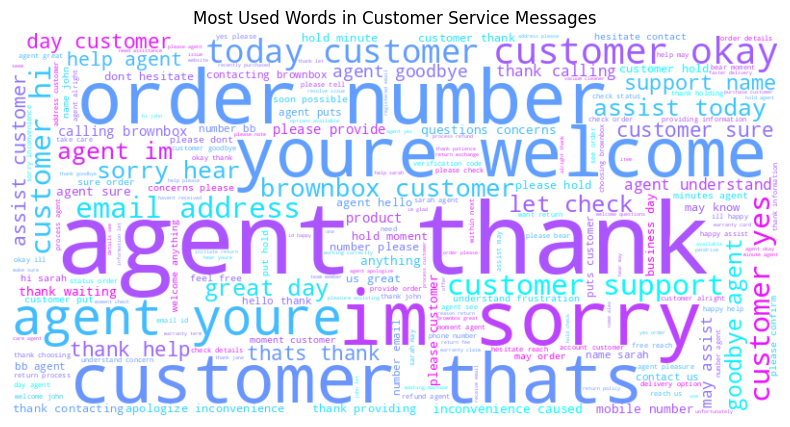

In [ ]:
#most used words with wordcloud
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

#stopwords with NLTK
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

#clearing the stopwords
def clean_msg(msg):
    msg = re.sub(r'[^a-zA-Z\s]', '', msg)  # clearing special chars
    msg = re.sub(r'http\S+', '', msg)  # clearing links
    msg = msg.lower()  # lowercase
    words = msg.split()
    words = [word for word in words if word not in stop_words]  # clearing stopwords
    return " ".join(words)

train_dataFrame["cleaned_text"] = train_dataFrame["conversation"].apply(clean_msg)

# combining messages
ful_words = " ".join(msg for msg in train_dataFrame["cleaned_text"])

# WordCloud visualization
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="cool").generate(ful_words)

# WordCloud'u çizelim
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Used Words in Customer Service Messages")
plt.show()

In [ ]:
#seeing whether the sentiments has a relation with message length
fig = px.box(train_dataFrame, x="customer_sentiment", y="conversation_length",
             title="Message Length",
             labels={"customer_sentiment": "Sentiment Class", "conversation_length": "Word Count"},
             color="customer_sentiment",
             color_discrete_sequence=px.colors.qualitative.Set1)

fig.show()

Horizontal Bar Chart for customer problem categories

In [ ]:
import plotly.express as px

# Count occurrences of each issue category
issue_counts = train_dataFrame["issue_category"].value_counts().reset_index()
issue_counts.columns = ["Support Issue Category", "Frequency"]  # Rename columns properly
#rename because a problem occurs without renameing

# bar chart
fig = px.bar(issue_counts, y="Support Issue Category", x="Frequency",
             labels={"Support Issue Category": "Issue Category", "Frequency": "Count"},
             title="Customer Support Issues Distribution",
             orientation="h",
             color="Frequency",
             color_continuous_scale="Blues")

# Set black background because in Bues colormap the whites doesnt shown
fig.update_layout(
    plot_bgcolor="black",
    paper_bgcolor="black",
    font=dict(color="white")
)

fig.show()


Most common words that used wih a bar chart

In [ ]:
# combining the messages
all_words = " ".join(text for text in train_dataFrame["conversation"])
word_counts = Counter(all_words.split())

# getting the most used 20
common_words = pd.DataFrame(word_counts.most_common(20), columns=["Word", "Frequency"])

fig = px.bar(common_words, x="Frequency", y="Word",
             title="Most Frequently Used Words in Customer Messages",
             color="Frequency",
             color_continuous_scale="Magma",
             orientation="h")

# fig.update_layout(
#     plot_bgcolor="black",
#     paper_bgcolor="black",
#     font=dict(color="white")
# )

fig.show()


Bigram analysis for seeingthe  most used 2-word phrases

In [ ]:
# Creatin the 2 word bigrams
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words="english")
X = vectorizer.fit_transform(train_dataFrame["cleaned_text"])

# Get top bigrams
bigram_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False).head(15)

fig = px.bar(bigram_counts.reset_index(), x=0, y="index",
             title="Most Frequent 2-Word Phrases (Bigrams)",
             labels={"index": "Bigram", 0: "Frequency"},
             color=0,
             color_continuous_scale="Inferno",
             orientation="h")

fig.show()
